# The table below represents prices of oil (US dollars per barrel).

Source: https://www.kaggle.com/mabusalah/brent-oil-prices

Import libraries

In [1]:
import pandas as pd
import numpy as np

import datetime

from copy import deepcopy

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams

import seaborn as sns
sns.set()

from tqdm import tqdm

from sklearn.linear_model import LinearRegression

from hmmlearn.hmm import GaussianHMM

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Functions we'll need later

In [2]:
#test stationarity with Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
#plot time series
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Import dataset

In [4]:
dataset = pd.read_csv("BrentOilPrices.csv", parse_dates=['Date'], infer_datetime_format = True)
dataset

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
8549,2021-01-19,55.38
8550,2021-01-20,55.66
8551,2021-01-21,55.68
8552,2021-01-22,55.22


Let's take a look on plot.

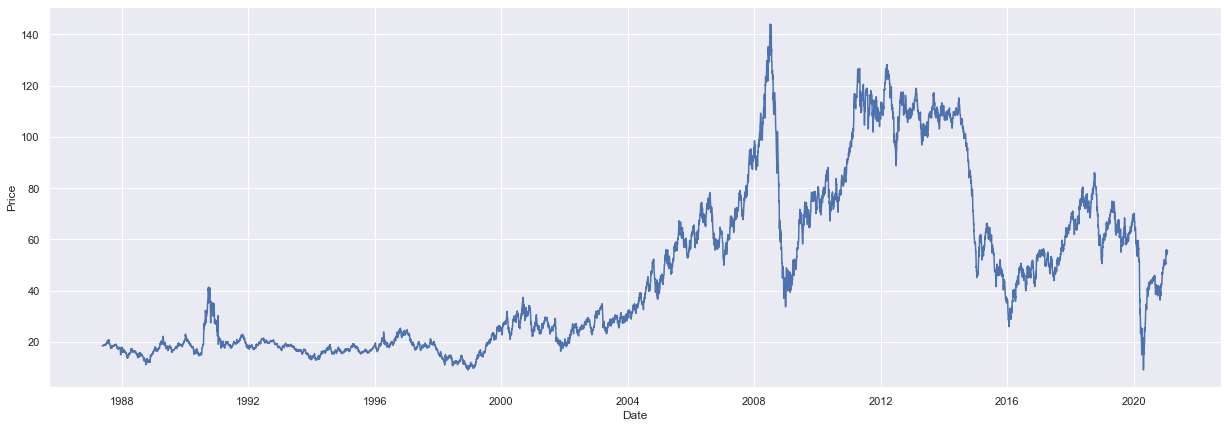

In [5]:
plt.figure(figsize = (21, 7))
sns.lineplot(x = dataset['Date'], y = dataset['Price'])

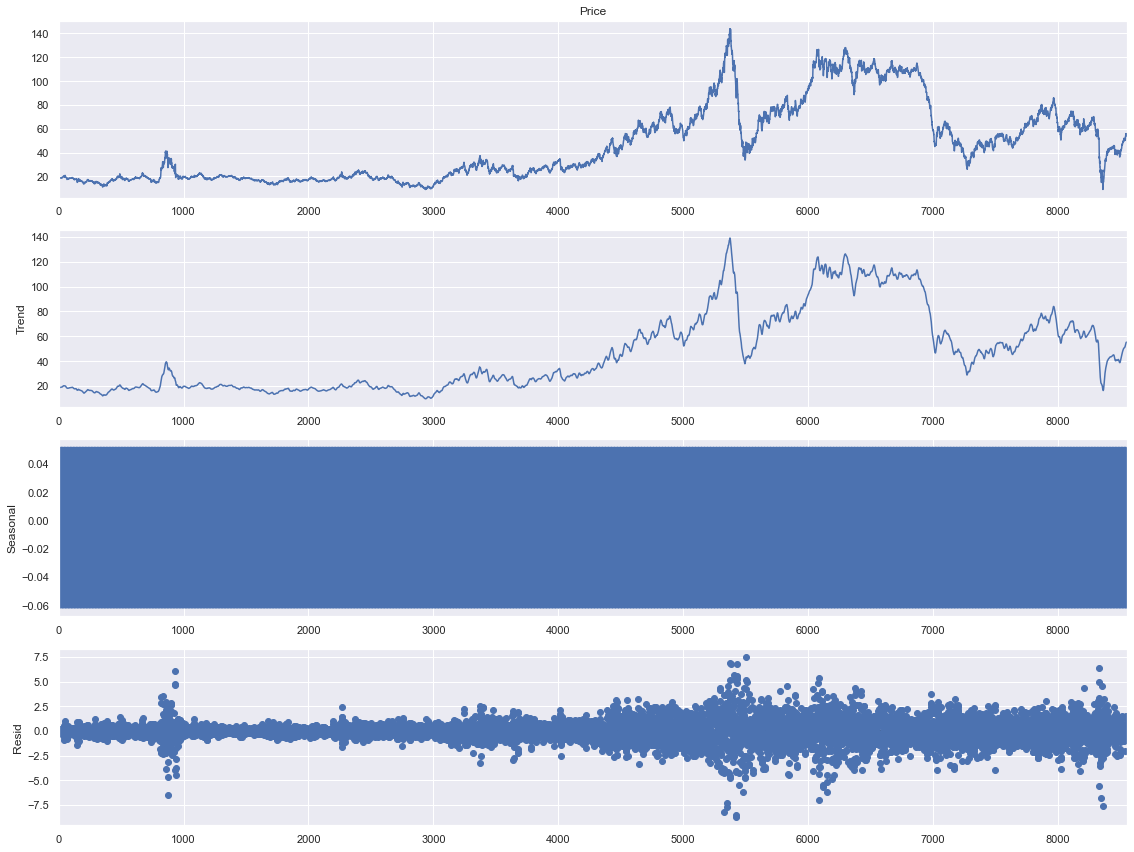

In [6]:
decomposed = sm.tsa.seasonal_decompose(dataset['Price'], period=12) 

rcParams['figure.figsize'] = 16, 12
decomposed.plot()
plt.show()

Let's run Dickey-Fuller test.

Results of Dickey-Fuller Test:
Test Statistic                   -2.119950
p-value                           0.236569
#Lags Used                       29.000000
Number of Observations Used    8524.000000
Critical Value (1%)              -3.431117
Critical Value (5%)              -2.861879
Critical Value (10%)             -2.566951
dtype: float64


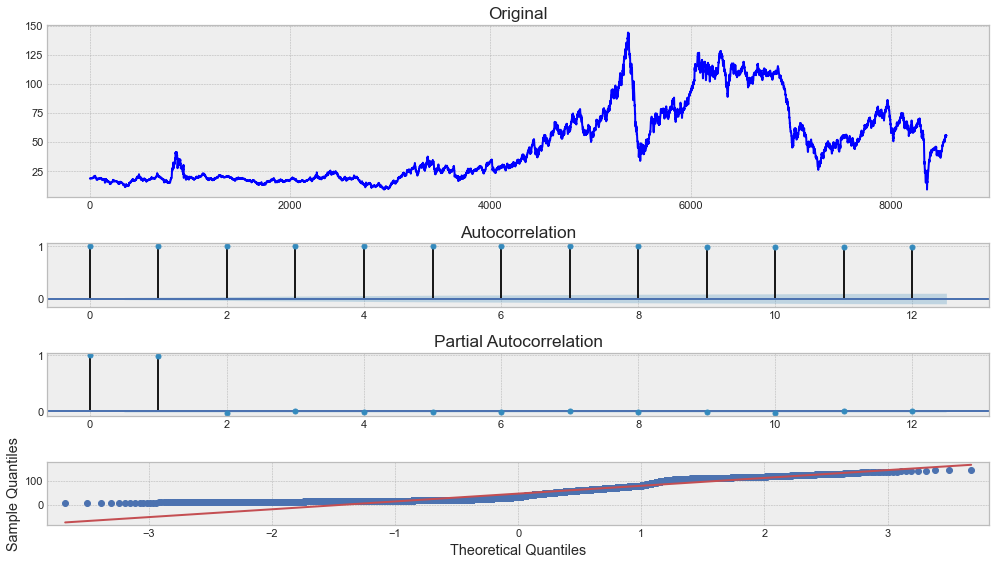

In [7]:
tsplot(dataset['Price'], lags = 12)

P-value is big and we can see that residuals aren't normally distributed. On the autocorrelation plot  values are not in the confidence area.

Now let's fix our series.

In [8]:
series_original = dataset['Price']
series_copy = deepcopy(dataset['Price'])

In [9]:
series_boxcox = boxcox(series_copy, 0.1)
series_boxcox_diff = np.diff(series_boxcox)

Results of Dickey-Fuller Test:
Test Statistic                -1.588475e+01
p-value                        8.675966e-29
#Lags Used                     2.800000e+01
Number of Observations Used    8.524000e+03
Critical Value (1%)           -3.431117e+00
Critical Value (5%)           -2.861879e+00
Critical Value (10%)          -2.566951e+00
dtype: float64


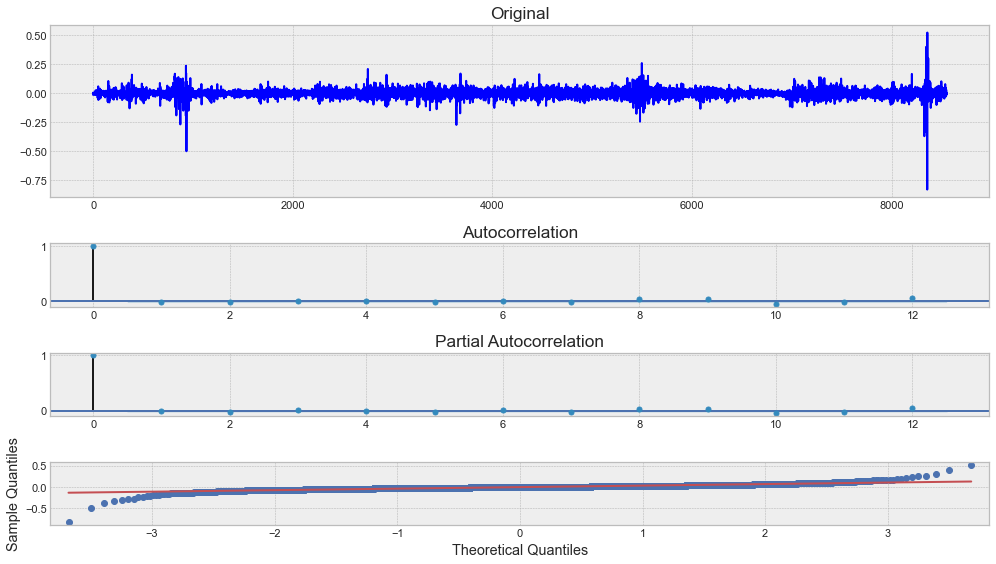

In [10]:
tsplot(series_boxcox_diff, lags = 12)

As we can see our series now is close to stationary. To be sure in that let's split series onto parts and check them.

In [11]:
df = pd.DataFrame(series_boxcox_diff)

In [12]:
m = df.index[int(len(df.index)/2 + 1)]
r1 = sm.stats.DescrStatsW(df[m:])
r2 = sm.stats.DescrStatsW(df[:m])
print ('p-value: ', sm.stats.CompareMeans(r1, r2).ttest_ind()[1])

p-value:  [0.96302624]


High p-value gives us standing to assert that null hypothesis about equality of means is true which represents about stationarity of series. 

## Models:

Here I didn't use ARIMA or GARCH 'cause they haven't given good enough results. So we won't use all this information about series stationarity we figured out above.

### 1. Linear Regression.

Generate features by adding lags and split data onto train and test.

In [13]:
def prepareData(data, lag_start=5, lag_end=20, test_index=8000):
    data = pd.DataFrame(data.copy())
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['Price'].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:test_index].drop('Price', axis = 1)
    y_train = data.iloc[:test_index]['Price']
    X_test = data.iloc[test_index:].drop('Price', axis = 1)
    y_test = data.iloc[test_index:]['Price']
    
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = prepareData(series_original, lag_start=1, lag_end=20, test_index = 8000)

Fit model and predict future values on test.

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
prediction_lin_reg = lin_reg.predict(X_test)

Plotting predicted and actual values.

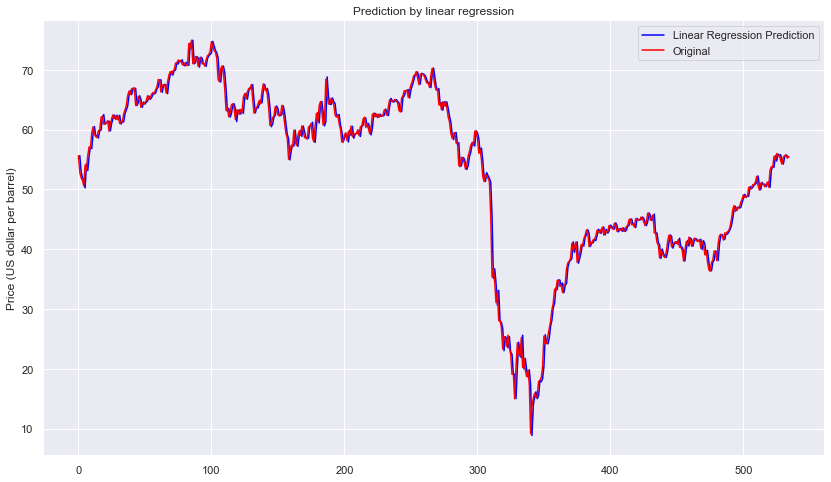

In [16]:
plt.figure(figsize=(14, 8))
plt.title('Prediction by linear regression')
plt.ylabel('Price (US dollar per barrel)')
plt.plot(prediction_lin_reg, color = 'blue', label = 'Linear Regression Prediction')
plt.plot(y_test.values, color = 'red', label = 'Original')
plt.legend()
plt.show()

Evaluating prediction

In [17]:
rmse_lin_reg = mean_squared_error(y_test, prediction_lin_reg) ** (1 / 2)
rmse_lin_reg

1.5030313264992412

In [18]:
mae = mean_absolute_error(y_test, prediction_lin_reg)
mae

1.0358261628839827

Our mistake is about 1 US dollar per barrel which seems really nice.

### 2. Hidden Markov Model with Gaussian emissions

Prepare data

In [19]:
values = series_original.values.reshape(-1,1)

Split data onto train and test samples

In [20]:
N = 8000
train = values[:N]
test = values[N:]

In [21]:
def get_best_params():
    scores = []
    for n in tqdm(range(15, 35)):
        model = GaussianHMM(n_components=n, covariance_type="diag", n_iter=10000)
        model.fit(values)
        scores.append(model.score(train))
    max_value = max(scores)
    return scores.index(max_value) + 15

In [22]:
#%%time
#get_best_params()

Create and fit best model

In [23]:
model_hmm = GaussianHMM(n_components=34, covariance_type="diag", algorithm = 'map', n_iter=10000, random_state = 42)

In [24]:
%%time
model_hmm.fit(train)

Wall time: 51.1 s


GaussianHMM(algorithm='map', n_components=34, n_iter=10000, random_state=42)

Predict values

In [25]:
prediction_hmm = model_hmm.predict(test)

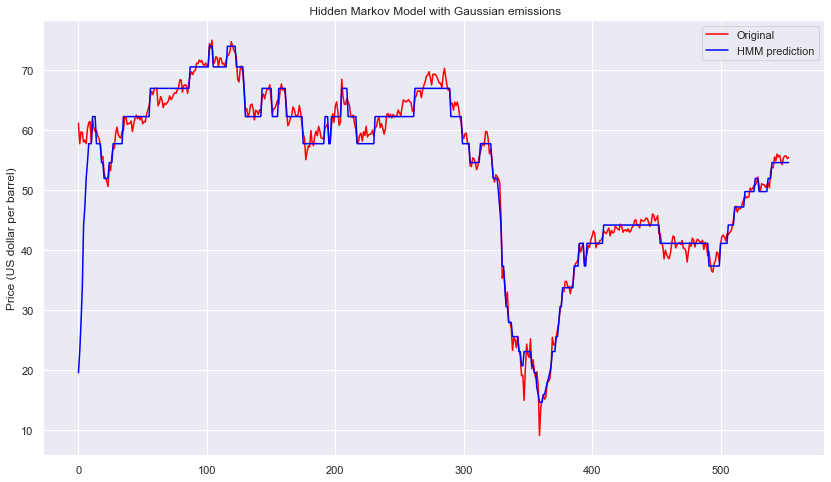

In [26]:
labels = model_hmm.predict(test)
means = np.zeros_like(test)
for i in range(model_hmm.n_components):
    means[labels == i] = model_hmm.means_[i]
    
plt.figure(figsize=(14, 8))
plt.title(' Hidden Markov Model with Gaussian emissions')
plt.ylabel('Price (US dollar per barrel)')
plt.plot(test, color = 'red', label = 'Original')
plt.plot(means, color = 'blue', label = 'HMM prediction')
plt.legend()
plt.show()

Evaluating prediction

In [27]:
rmse_hmm = mean_squared_error(test, prediction_hmm) ** (1 / 2)
rmse_hmm

41.01054663594551

In [28]:
mae_hmm = mean_absolute_error(test, prediction_hmm)
mae_hmm

37.475451263537906

So out best model was logistic regression. 